## 1. Import and Functions

In [4]:
import rdkit
import copy
import pandas as pd
from rdkit import Chem 
from rdkit.Chem import Draw, Kekulize, SanitizeMol, PandasTools, Descriptors
from rdkit.Chem.rdmolops import CombineMols
from rdkit import RDLogger
from utils import * 
RDLogger.DisableLog('rdApp.error')

In [5]:
def idx_annotate(x):
    """
    Taken from: https://iwatobipen.wordpress.com/2017/02/25/draw-molecule-with-atom-index-in-rdkit/
    
    Add label to each molecule's atom: "atom_name:atom_index"
    """
    mol = copy.deepcopy(x)
    for idx in range(mol.GetNumAtoms()):
        mol.GetAtomWithIdx(idx).SetProp(
            'molAtomMapNumber', 
            str(mol.GetAtomWithIdx(idx).GetIdx())
        )
    return mol

def mol(x) : 
    return Chem.MolFromSmiles(x)

def draw(x) : 
    if type(x) == str : x = mol(x)
    Draw.MolToImage(x).show()

def auto_add(x, y, manual_select=False) : 
    if type(x) == str : x = mol(x)
    if type(y) == str : y = mol(y)
    
    combo = CombineMols(x, y) 
    output = []
    add_atom = None

    if isinstance(manual_select, bool) and manual_select : 
        draw(idx_annotate(x))
        add_atom = int(input("Select atom to add to: "))
    elif isinstance(manual_select, int) : 
        add_atom = manual_select

    for i in range(x.GetNumAtoms()) :
        if add_atom is not None: i = add_atom
        for j in range(x.GetNumAtoms(), combo.GetNumAtoms()) :
            for b in [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE] :
                combo_editable = Chem.EditableMol(combo)
                combo_editable.AddBond(i, j, order=b)

                try : 
                    Chem.SanitizeMol(combo_editable.GetMol())
                    output.append(Chem.MolToSmiles(combo_editable.GetMol()))
                except : pass
        if add_atom is not None: break
    return output

## 2. Combine molecules

In [6]:
core = Chem.MolFromSmiles('Cn1cnc2c(N[C@H]3CCCNC3)ncnc12')

sulfonyl_halide = read_smi('data/Enamine_Full_SulfonylHalides.sdf')
aryl_halide = read_smi('data/Enamine_Full_ArylHalides.sdf')
secondary_amines = read_smi('data/Enamine_Full_SecondaryAmines.sdf')

sulfonyl_halide_output, aryl_halide_output, secondary_amines_output = [], [], []

Reading SMILES: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32294/32294 [00:03<00:00, 8236.06it/s]


In [ ]:
def auto_add(x, y, manual_select=False) : 
    if type(x) == str : x = mol(x)
    if type(y) == str : y = mol(y)
    
    combo = CombineMols(x, y) 
    output = []
    add_atom = None

    if isinstance(manual_select, bool) and manual_select : 
        draw(idx_annotate(x))
        add_atom = int(input("Select atom to add to: "))
    elif isinstance(manual_select, int) : 
        add_atom = manual_select

    for i in range(x.GetNumAtoms()) :
        if add_atom is not None: i = add_atom
        for j in range(x.GetNumAtoms(), combo.GetNumAtoms()) :
            for b in [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE] :
                combo_editable = Chem.EditableMol(combo)
                combo_editable.AddBond(i, j, order=b)

                try : 
                    Chem.SanitizeMol(combo_editable.GetMol())
                    output.append(Chem.MolToSmiles(combo_editable.GetMol()))
                except : pass
        if add_atom is not None: break
    return output

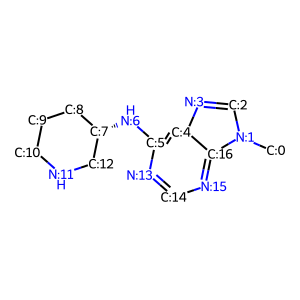

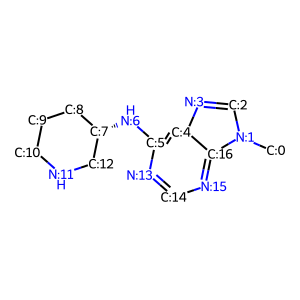

ValueError: invalid literal for int() with base 10: ''

In [8]:
for i in sulfonyl_halide : 
    output = auto_add(core, i, manual_select=True)
    for o in output : 
        sulfonyl_halide_output.append(o)

In [4]:
for i in sulfonyl_halide : 
    output = auto_add(core, i, manual_select=14)
    for o in output : 
        sulfonyl_halide_output.append(o)

for i in aryl_halide : 
    output = auto_add(core, i, manual_select=14)
    for o in output : 
        aryl_halide_output.append(o)

for i in secondary_amines :
    output = auto_add(core, i, manual_select=14)
    for o in output : 
        secondary_amines_output.append(o)

## 3. Filtering

In [5]:
aryl_halide_combinations = read_smi('data/output/aryl_halide_combinations.txt')
secondary_amines_combinations = read_smi('data/output/secondary_amines_combinations.txt')
sulfonyl_halide_combinations = read_smi('data/output/sulfonyl_halide_combinations.txt')

Reading SMILES: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32421/32421 [00:04<00:00, 7603.78it/s]


In [7]:
def clean_mixture_molecules(smiles_list) : 
    return [s for s in tqdm(smiles_list) if '.' not in s]

In [10]:
aryl_halide_combinations_no_mixture = clean_mixture_molecules(aryl_halide_combinations)
secondary_amines_combinations_no_mixture = clean_mixture_molecules(secondary_amines_combinations)
sulfonyl_halide_combinations_no_mixture = clean_mixture_molecules(sulfonyl_halide_combinations)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32421/32421 [00:00<00:00, 4780577.61it/s]


## 4. Calculate properties

In [51]:
aryl_halide_df = pd.DataFrame(aryl_halide_combinations_no_mixture, columns=['SMILES'])
secondary_amines_df = pd.DataFrame(secondary_amines_combinations_no_mixture, columns=['SMILES'])
sulfonyl_halide_df = pd.DataFrame(sulfonyl_halide_combinations_no_mixture, columns=['SMILES'])

PandasTools.AddMoleculeColumnToFrame(aryl_halide_df, 'SMILES')
PandasTools.AddMoleculeColumnToFrame(secondary_amines_df, 'SMILES')
PandasTools.AddMoleculeColumnToFrame(sulfonyl_halide_df, 'SMILES')

Failed to patch pandas - unable to change molecule rendering
Failed to patch pandas - unable to change molecule rendering
Failed to patch pandas - unable to change molecule rendering


In [52]:
desired_desc = ['qed', 'ExactMolWt', 'TPSA', 'NumHAcceptors', 'NumHDonors', 'NHOHCount', 'NOCount', 'NumRotatableBonds', 'RingCount', 'MolLogP']

def calculate_properties(df) : 
    copy_df = copy.deepcopy(df)
    desc_func = [f[1] for f in Descriptors._descList if f[0] in desired_desc]
    for i, func in enumerate(desc_func) : 
        print(f'Calculating {desired_desc[i]}...')
        copy_df[desired_desc[i]] = copy_df['ROMol'].apply(func)
    return copy_df

In [53]:
aryl_halide_df_calculated = calculate_properties(aryl_halide_df)
secondary_amines_df_calculated = calculate_properties(secondary_amines_df)
sulfonyl_halide_df_calculated = calculate_properties(sulfonyl_halide_df)

Calculating qed...
Calculating ExactMolWt...
Calculating TPSA...
Calculating NumHAcceptors...
Calculating NumHDonors...
Calculating NHOHCount...
Calculating NOCount...
Calculating NumRotatableBonds...
Calculating RingCount...
Calculating MolLogP...
Calculating qed...
Calculating ExactMolWt...
Calculating TPSA...
Calculating NumHAcceptors...
Calculating NumHDonors...
Calculating NHOHCount...
Calculating NOCount...
Calculating NumRotatableBonds...
Calculating RingCount...
Calculating MolLogP...
Calculating qed...
Calculating ExactMolWt...
Calculating TPSA...
Calculating NumHAcceptors...
Calculating NumHDonors...
Calculating NHOHCount...
Calculating NOCount...
Calculating NumRotatableBonds...
Calculating RingCount...
Calculating MolLogP...


In [54]:
PandasTools.WriteSDF(aryl_halide_df_calculated, 'data/output/aryl_halide_combinations_calculated.sdf', properties=desired_desc)
PandasTools.WriteSDF(secondary_amines_df_calculated, 'data/output/secondary_amines_combinations_calculated.sdf', properties=desired_desc)
PandasTools.WriteSDF(sulfonyl_halide_df_calculated, 'data/output/sulfonyl_halide_combinations_calculated.sdf', properties=desired_desc)

In [57]:
aryl_halid_df_nomol = aryl_halide_df_calculated.drop(columns=['ROMol'])
secondary_amines_df_nomol = secondary_amines_df_calculated.drop(columns=['ROMol'])
sulfonyl_halide_df_nomol = sulfonyl_halide_df_calculated.drop(columns=['ROMol'])

aryl_halid_df_nomol.to_csv('data/output/aryl_halide_combinations_calculated.csv', index=False)
secondary_amines_df_nomol.to_csv('data/output/secondary_amines_combinations_calculated.csv', index=False)
sulfonyl_halide_df_nomol.to_csv('data/output/sulfonyl_halide_combinations_calculated.csv', index=False)